# 案例分析(3) —— VTI 股价预测(线性回归)

# 1、股票

- 时间序列
- 统计规律性

# 2、VTI 数据获取

- 直接下载
    - [雅虎财经](https://finance.yahoo.com/quote/VTI/)
- 爬虫
    - 方法一：requests 模块
    - 方法二：pandas_datareader 模块<font color='red'>（建议）</font>
        - pip install pandas_datareader

https://www.vivaetf.com/cn/article/index/id/277.html  VTI理解一下

## 2.1 requests 模块

In [1]:
import requests
import re
import json
import pandas as pd
from datetime import date

In [2]:
def retrieve_quotes_historical(stock_code):
    quotes = []
    url = 'http://finance.yahoo.com/quote/%s/history?p=%s' % (stock_code, stock_code)
    r = requests.get(url)
    m = re.findall('"HistoricalPriceStore":{"prices":(.*?),"isPending"', r.text)
    if m:
        quotes = json.loads(m[0])
        quotes = quotes[::-1]
    return  [item for item in quotes if not 'type' in item]
# https://finance.yahoo.com/lookup  登陆查看

In [3]:
quotes = retrieve_quotes_historical('VTI')
list1 = []
for i in range(len(quotes)):
    x = date.fromtimestamp(quotes[i]['date'])
    y = date.strftime(x,'%Y-%m-%d')
    list1.append(y)
quotes_df_raw = pd.DataFrame(quotes, index = list1)
quotes_df = quotes_df_raw.drop(['date'], axis = 1)

In [4]:
quotes_df.head()

,adjclose,close,high,low,open,volume
2018-05-29,136.420792,139.210007,140.160004,138.539993,139.800003,2695000
2018-05-30,138.184708,141.009995,141.309998,139.910004,139.970001,1587000
2018-05-31,137.234116,140.039993,140.949997,139.809998,140.880005,1700900
2018-06-01,138.664886,141.500000,141.649994,140.759995,140.929993,1857800
2018-06-04,139.311661,142.160004,142.259995,141.729996,141.899994,1592000


In [5]:
quotes_df.tail()

,adjclose,close,high,low,open,volume
2019-04-30,150.389999,150.389999,150.600006,149.300003,150.279999,2224500
2019-05-01,149.270004,149.270004,150.869995,149.240005,150.800003,3761300
2019-05-02,149.020004,149.020004,149.740005,148.059998,149.149994,2537800
2019-05-03,150.630005,150.630005,150.699997,149.699997,149.800003,2147100
2019-05-06,149.145004,149.145004,149.320007,148.022400,148.190002,867069


## 2.2 pandas_datareader 模块

#### (1) 导入模块

In [5]:
import pandas as pd
import pandas_datareader.data as web   
import datetime

#### (2) 设置股票数据的起点和终点

- datetime 模块的 datetime 类

In [6]:
start = datetime.datetime(2015, 11, 25)
end = datetime.datetime(2018, 11, 23)

In [7]:
type(start), type(end)

(datetime.datetime, datetime.datetime)

#### (3) 获取数据

In [8]:
VTI_df_raw = web.DataReader("VTI", "yahoo", start, end)

In [9]:
VTI_df_raw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-24,107.589996,106.309998,106.570000,107.389999,2032600.0,100.287285
2015-11-25,107.660004,107.250000,107.510002,107.470001,1820300.0,100.361992
2015-11-27,107.760002,107.220001,107.589996,107.629997,552400.0,100.511406
2015-11-30,107.849998,107.110001,107.779999,107.169998,3618100.0,100.081833
2015-12-01,108.209999,107.370003,107.589996,108.180000,2443600.0,101.025032


In [10]:
VTI_df_raw.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-11-16,140.570007,138.820007,139.070007,140.080002,2272300.0,138.513260
2018-11-19,139.929993,137.169998,139.830002,137.649994,3481800.0,136.110428
2018-11-20,136.619995,134.639999,135.729996,135.199997,4627200.0,133.687836
2018-11-21,136.889999,135.750000,136.000000,135.860001,4151300.0,134.340469
2018-11-23,135.919998,134.729996,134.919998,135.130005,1300000.0,133.618622


- 缺少数据？
    - 节假日和周末不开盘

#### (4) 写到 csv 文件中

In [11]:
VTI_df_raw.to_csv("VTI.csv")

# 3、股价预测 —— 线性回归算法

## 3.1 目标

- 使用线性回归（Linear Regression）预测下一天的股票价格
- 已知前 N 天的价格，训练模型，预测第 N+1 天的价格

## 3.2 导入模块

#### (1) tqdm
- 可能没有预装
- 功能
    - 在 Python 长循环中添加进度提示信息
- 安装
    - pip install tqdm

In [12]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from matplotlib import style
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

## 3.3 参数设置

- 同学们可以更改参数，重新运行试试看

In [13]:
stk_path = "./VTI.csv"
cv_size = 0.2                   # 交叉验证集 (cross-validation set) 占总数据集 (dataset) 的比例
test_size = 0.2                 # 测试集 (test set) 占总数据集的比例

Nmax = 30                       # 对于第 t 天，以 t-1, t-2, ..., t-N 作为特征
                                # Nmax 是测试的最大数目 N
fontsize = 14
ticklabelsize = 14

## 3.4 通用函数

#### (1) 线性回归预测

In [14]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    对于一个 DataFrame，通过时间步 t-1, t-2, ..., t-N 的值来预测时间步 t 的值
    输入：
        df         : 带预测值的 dataframe，可为任意长度
        target_col : 要预测的列名，比如'Adj Close'
        N          : 通过时间步 t-1, t-2, ..., t-N 的值来预测时间步 t 的值
        pred_min   : 所有预测应该 >= pred_min
        offset     : 对于 df，我们只预测 df[offset:]，offset 可以是训练集的大小
    输出：
        pred_list  : 对 target_col 的预测值，np.array 对象，长度为 len(df)-offset
    """
    # 创建线性回归对象
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(np.arange(N)) # e.g. [0 1 2 3 4]
        y_train = df['adj_close'][i-N:i].values  # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        y_train = y_train.reshape(-1, 1)

        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array([[N]]))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

#### (2) 计算平均绝对百分比误差

In [15]:
def get_mape(y_true, y_pred): 
    """
    计算平均绝对百分比误差 Mean Absolute Percentage Error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 3.5 导入数据

#### (1) 导入并简单处理

In [22]:
df = pd.read_csv(stk_path, sep = ",")

# 把第一列的 Date 转换成 datetime 对象
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [23]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
751,2018-11-16,140.570007,138.820007,139.070007,140.080002,2272300.0,138.513260
752,2018-11-19,139.929993,137.169998,139.830002,137.649994,3481800.0,136.110428
753,2018-11-20,136.619995,134.639999,135.729996,135.199997,4627200.0,133.687836
754,2018-11-21,136.889999,135.750000,136.000000,135.860001,4151300.0,134.340469
755,2018-11-23,135.919998,134.729996,134.919998,135.130005,1300000.0,133.618622


In [24]:
# 把所有列名转成小写，并把空格替换成下划线  比如 Date -> date , Adj Close -> adj_close
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.tail()

,date,high,low,open,close,volume,adj_close
751,2018-11-16,140.570007,138.820007,139.070007,140.080002,2272300.0,138.513260
752,2018-11-19,139.929993,137.169998,139.830002,137.649994,3481800.0,136.110428
753,2018-11-20,136.619995,134.639999,135.729996,135.199997,4627200.0,133.687836
754,2018-11-21,136.889999,135.750000,136.000000,135.860001,4151300.0,134.340469
755,2018-11-23,135.919998,134.729996,134.919998,135.130005,1300000.0,133.618622


In [26]:
# 加一列：月份列
df['month'] = df['date'].dt.month

# 根据 datetime 进行升序排序，原地排序
df.sort_values(by='date', inplace=True, ascending=True)

df.tail()

,date,high,low,open,close,volume,adj_close,month
751,2018-11-16,140.570007,138.820007,139.070007,140.080002,2272300.0,138.513260,11
752,2018-11-19,139.929993,137.169998,139.830002,137.649994,3481800.0,136.110428,11
753,2018-11-20,136.619995,134.639999,135.729996,135.199997,4627200.0,133.687836,11
754,2018-11-21,136.889999,135.750000,136.000000,135.860001,4151300.0,134.340469,11
755,2018-11-23,135.919998,134.729996,134.919998,135.130005,1300000.0,133.618622,11


#### (2) 绘制adjusted close随时间变化曲线

In [27]:
style.use('ggplot')

Text(0,0.5,'USD')

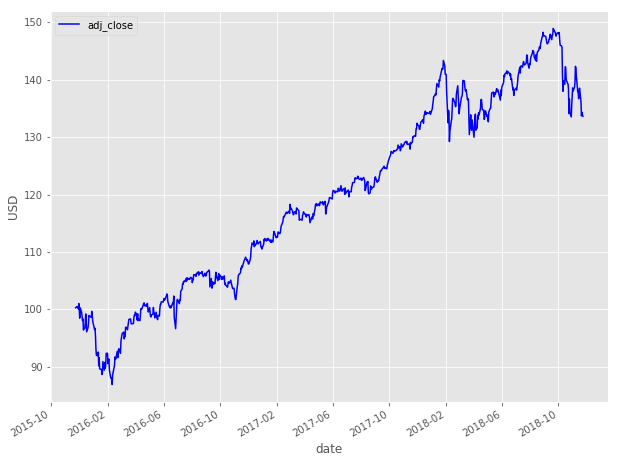

In [28]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

## 3.6 将数据集分成训练集、验证集、测试集

#### (1) 获取各个集的大小

In [29]:
# Get sizes of each of the datasets

num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 454
num_cv = 151
num_test = 151


#### (2) 数据集的分割
- 时间序列

In [30]:
# Split into train, cv, and test

train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (454, 8)
cv.shape = (151, 8)
train_cv.shape = (605, 8)
test.shape = (151, 8)


#### (3) 绘图

Text(0,0.5,'USD')

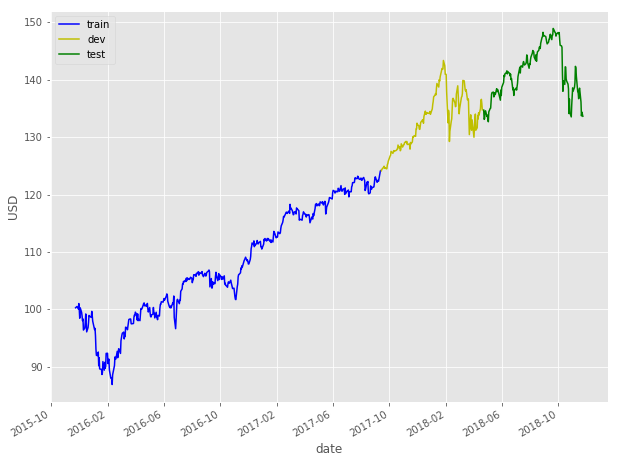

In [31]:
# Plot adjusted close over time

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

## 3.7 使用线性回归进行预测

#### (1) 评估指标
- RMSE 
    - 均方根误差（Root Mean Squared Error）
- R2 
    - R平方值 = 回归平方和(ssreg)/总平方和(sstotal)
- MAPE 
    - 平均绝对百分比误差（Mean Absolute Percentage Error MAPE）

In [35]:
RMSE = []
R2 = []
mape = []

# 使用 train 的 N 个数据来预测 cv 的 Nmax 个数据
# est_N1 表示只用了 train 的 1 个数据来预测 cv
# est_N30 表示用了 train 的 30 个数据来预测 cv

for N in range(1, Nmax+1):  # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.insert(cv.shape[1], 'est' + '_N' + str(N), est_list)  # 添加一列，直接用字典方式添加，会报 warning
    
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
    
print('RMSE = ' + str(RMSE), end='\n')
print('R2 = ' + str(R2), end='\n')
print('MAPE = ' + str(mape), end='\n')

cv.head()

RMSE = [1.184796899884653, 1.6903879192067406, 1.6042136658403083, 1.4205442155367576, 1.3469949519496496, 1.367999897925056, 1.420807361938742, 1.4589126395556915, 1.546017904307418, 1.6410939097264596, 1.726665546711586, 1.8153234397711904, 1.8973287129621972, 1.9752278420424438, 2.0423872595933017, 2.1023002133005573, 2.1525546735502674, 2.187066174390601, 2.214446667361951, 2.245783252977276, 2.282625523326146, 2.319899798611792, 2.3570037085006157, 2.3951561294180648, 2.4360952244166776, 2.4802275369378566, 2.5197277734552745, 2.552312443869457, 2.5831908056259976, 2.607553717248309]
R2 = [0.9365825514689939, 0.8709096710954157, 0.8837359706674301, 0.9088345124611381, 0.9180303872959139, 0.915453997764739, 0.9088007337279586, 0.9038433065917425, 0.8920183436040481, 0.8783287935604986, 0.8653093671493003, 0.851122530786738, 0.8373679617455025, 0.8237393594599389, 0.8115495702520903, 0.8003311045092288, 0.7906710336384867, 0.7839049621815873, 0.7784603846926222, 0.7721460169931273, 

,date,high,low,open,close,volume,adj_close,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
454,2017-09-14,128.479996,128.070007,128.229996,128.360001,1493200.0,124.132904,9,124.171593,124.229622,...,123.574264,123.412880,123.381612,123.365068,123.198331,123.044165,122.886158,122.767802,122.683397,122.590863
455,2017-09-15,128.619995,128.199997,128.309998,128.600006,1531300.0,124.365013,9,124.132904,124.094215,...,123.991484,123.820807,123.662024,123.626841,123.605950,123.440901,123.287120,123.128995,123.008579,122.920711
456,2017-09-18,129.100006,128.690002,128.850006,128.910004,1792300.0,124.664795,9,124.365013,124.597122,...,124.447436,124.233257,124.067048,123.910937,123.872475,123.847845,123.684584,123.531405,123.373423,123.251338
457,2017-09-19,129.100006,128.850006,129.059998,128.970001,1241700.0,124.722832,9,124.664795,124.964577,...,124.717616,124.693180,124.486595,124.324185,124.170333,124.128711,124.100479,123.938726,123.786001,123.628074
458,2017-09-20,129.210007,128.600006,129.100006,129.179993,1729200.0,124.925903,9,124.722832,124.780869,...,124.914577,124.930553,124.907138,124.708947,124.551458,124.401070,124.357842,124.327474,124.168233,124.016993


In [38]:
cv.shape


(151, 38)

In [40]:
len(RMSE)

30

#### (2) RMSE

In [41]:
style.use('ggplot')

(2, 30)

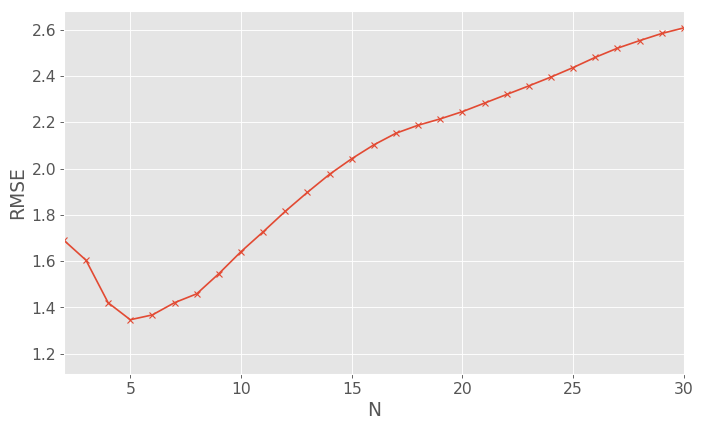

In [25]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid(True)
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

In [42]:
# 这个结果说明什么问题？

#### (3) R^2

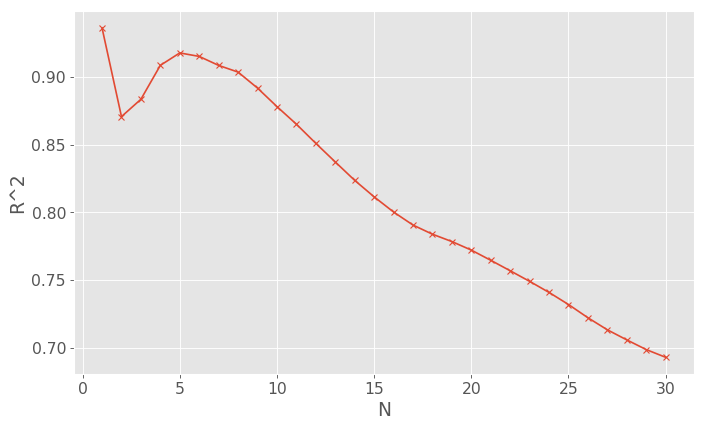

In [44]:
# Plot R2 versus N. Note for R2 larger better. 

matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid(True)
plt.xlabel('N')
plt.ylabel('R^2');

#### (4) MAPE

Text(0,0.5,'MAPE')

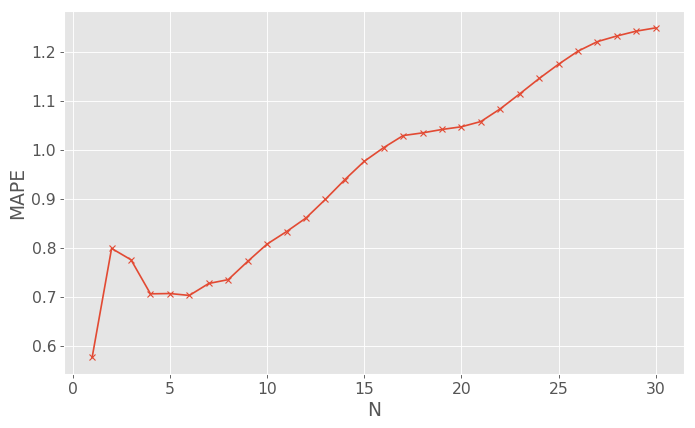

In [45]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(10, 6), dpi=80)

plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid(True)
plt.xlabel('N')
plt.ylabel('MAPE')

#### (5) 分析

- 基本规律
    - N 越大，误差越大
        - RMSE 越大
        - R^2 越小
        - MAPE 越大
- 最佳的 N
    - 5
    - 说明用 5 个最近的收盘价进行线性拟合，再预测当日收盘价，是最准的

In [66]:
# Set optimum N
N_opt = 5

## 3.8 预测特定日

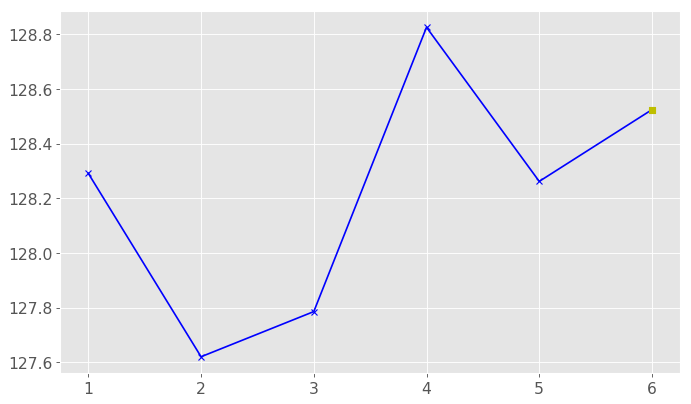

In [67]:
# 设置要预测的日子
day = pd.Timestamp(date(2017, 10, 31))

# 训练集是预测日子前面的数据
df_temp = cv[cv['date'] <= day]

# 1.画 Adj Close 的实际值
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(range(1, N_opt+2), df_temp[-N_opt-1:]['adj_close'], 'bx-')  # blue 颜色 x 形
plt.plot(N_opt+1, df_temp[-1:]['adj_close'], 'ys-')  # yellow 颜色 square 方形
legend_list = ['adj_close', 'actual_value']

In [70]:
# 2.线性预测
N = N_opt #######################
regr = LinearRegression(fit_intercept=True) # Create linear regression object
X_train = np.arange(N)  # e.g. [0 1 2 3 4]
y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
X_train = X_train.reshape(-1, 1)     
y_train = y_train.reshape(-1, 1)
regr.fit(X_train, y_train)            # Train the model
y_lr = regr.predict(X_train)          # Get linear regression line
y_pred = regr.predict(np.array([[N_opt]]))

In [71]:
# check
np.arange(N)

array([0, 1, 2, 3, 4])

In [72]:
np.array(df_temp['adj_close'][-N-1:-1])

array([128.290802  , 127.62064362, 127.78575897, 128.82496643,
       128.26167297])

In [73]:
y_lr.shape, y_pred.shape

((5, 1), (1, 1))

In [74]:
np.concatenate((y_lr, y_pred)).shape

(6, 1)

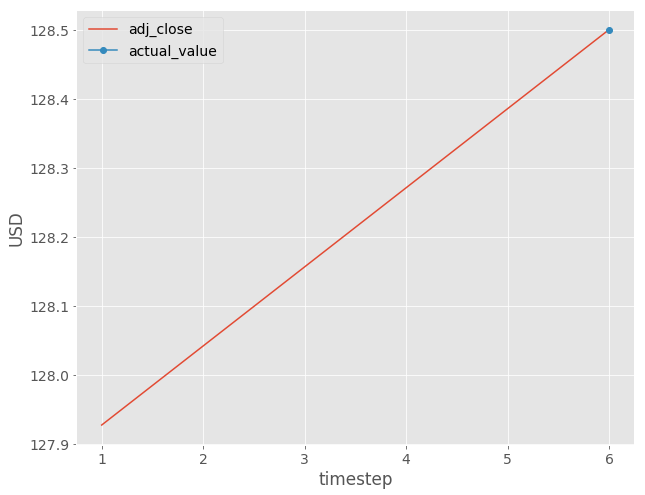

In [75]:
# 3.画线性拟合的曲线，以及预测日的收盘价
plt.plot(range(1, N_opt+2), np.concatenate((y_lr, y_pred)))
plt.plot(N_opt+1, np.squeeze(y_pred), marker='o')  # np.squeeze()从数组的形状中删除单维度条目，即把shape中为1的维度去掉
legend_list.extend(['est_N5_lr', 'ext_N5'])
    
plt.grid(True)
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list)
matplotlib.rcParams.update({'font.size': fontsize})

## 3.9 在验证集上进行预测

#### (1) 在整个时间序列上

Text(0,0.5,'USD')

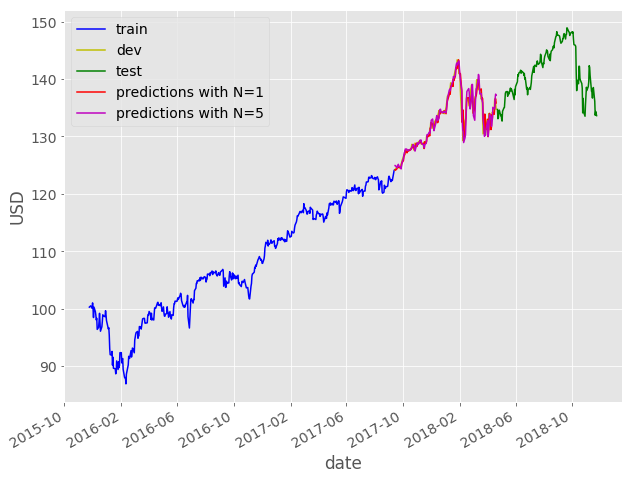

In [76]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

#### (2) 放大

Text(0.5,1,'Zoom in to dev set')

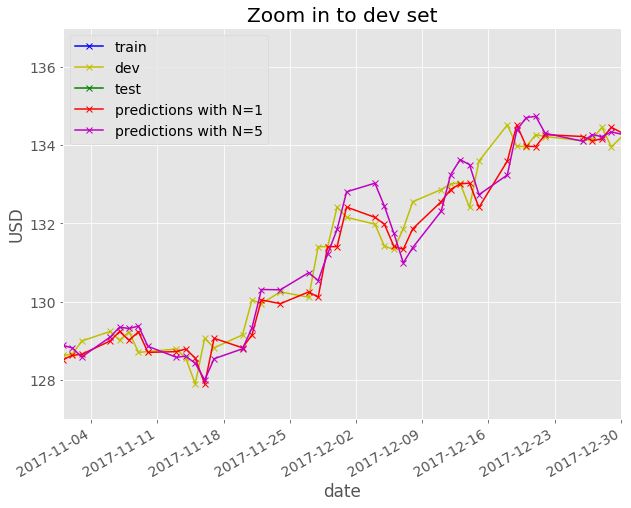

In [77]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 11, 1), date(2017, 12, 30)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

## 3.10 最终模型

#### (1) 线性回归

In [78]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)

test.insert(test.shape[1], 'est' + '_N' + str(N_opt), est_list)
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 1.404
R2 = 0.900
MAPE = 0.707%


,date,high,low,open,close,volume,adj_close,month,est_N5
605,2018-04-23,138.160004,136.809998,137.779999,137.449997,2033700.0,134.696030,4,135.398665
606,2018-04-24,138.190002,134.860001,138.100006,135.800003,3053500.0,133.079086,4,134.084531
607,2018-04-25,136.250000,134.610001,135.770004,135.949997,2275400.0,133.226089,4,132.550890
608,2018-04-26,137.679993,136.250000,136.520004,137.240005,1284600.0,134.490250,4,132.255919
609,2018-04-27,137.740005,136.800003,137.539993,137.330002,1133600.0,134.578445,4,133.453448


#### (2) 绘图 —— 在整个时间序列上

Text(0,0.5,'USD')

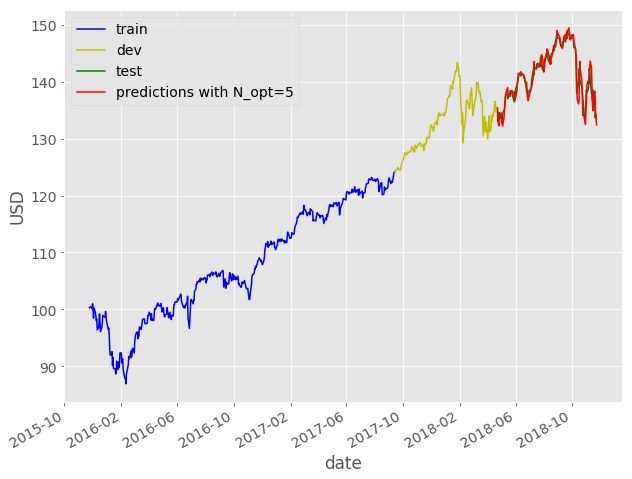

In [79]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

#### (3) 绘图 —— 放大特定区间

Text(0.5,1,'Zoom in to test set')

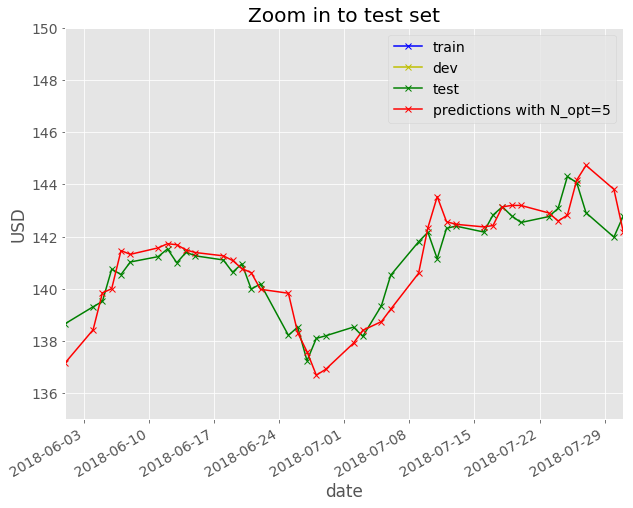

In [80]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 6, 1), date(2018, 7, 31)])
ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

#### (4) 绘图 —— 放大测试集部分

(130, 155)

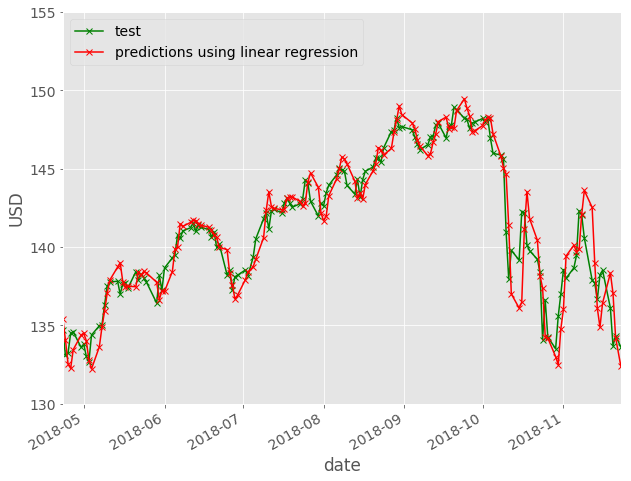

In [81]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])

In [82]:
# Save as csv
test_lin_reg = test
test_lin_reg.to_csv("./test_lin_reg.csv")

## 3.11 一些发现

- 在验证集上，当 N = 1 时，可得到最小的 RMSE，值为 1.19，也就是用第 t-1 天的值来预测第 t 天的值
- 在验证集上，当 N = 5 时，可得到次小的 RMSE，值为 1.36，也就是用第 t-5 ~ t-1 天的值来预测第 t 天的值
- 这里为了使用线性回归，采用 N_opt = 5
- 在测试集上，使用 N_opt = 5，得到了 RMSE = 1.42，MAPE = 0.707 %

## 案例分析(3) 结束